In [68]:
import pandas as pd
import numpy as np 
import scipy as sp 

#Visuallization 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix 
sns.set_style('whitegrid')
mpl.style.use('ggplot')
%matplotlib inline
pylab.rcParams['figure.figsize'] = 12,8

import random 
import time
import warnings 
warnings.filterwarnings('ignore')


In [110]:
# from sklearn.linear_model import LogisticRegression 
# from sklearn.svm import SVC, LinearSVC
# from sklearn.ensemble import RandomForestClassifier 
# from sklearn.naive_bayes import GaussianNB

from sklearn import svm, tree,linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

from sklearn.preprocessing import OneHotEncoder, LabelEncoder 
from sklearn import feature_selection 
from sklearn import model_selection 
from sklearn import metrics 


In [70]:
#Import data
path = '~/Documents/Kaggle/Titanic/'
data_raw = pd.read_csv(path+'train.csv')
data_val = pd.read_csv(path+'test.csv')

#make copy and group train and test dataset in list since they are both similar and can be treated with same operations and analysis
data = data_raw.copy(deep=True)
data_group = [data,data_val]

In [71]:
#checking missing values all fields 
print('train data missing values: ')
print(data.isnull().sum())
print('-'*20)
print('test data missing values: ')
print(data_val.isnull().sum())


train data missing values: 
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
--------------------
test data missing values: 
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [72]:
#Imputation missing values with median and mode values
for eachset in data_group: 
    eachset['Age'].fillna(eachset['Age'].median(),inplace=True)
    eachset['Embarked'].fillna(eachset['Embarked'].mode()[0],inplace=True)
    eachset['Fare'].fillna(eachset['Fare'].median(),inplace=True)
    
#list of columns to drop since they dont have useful info
drop_columns = ['PassengerId','Cabin','Ticket'] 
data.drop(drop_columns,axis=1,inplace=True)
print('train data missing')
print(data.isnull().sum())
print('-'*20)
print('test data missing')
print(data_val.isnull().sum())

train data missing
Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
--------------------
test data missing
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [73]:
### Feature egnineering
## Create FamilySize column by add number of SibSp and Parch
## Create IsAlone column 
## Create Title column extracted from Name column 


#creating new field called IsAlone, having 1 as True, 0 as False 
for eachset in data_group: 
    eachset['FamilySize'] = eachset['SibSp'] + eachset['Parch'] + 1
    eachset['IsAlone'] = 1 #initialize with 1
    eachset['IsAlone'].loc[eachset['FamilySize']>1]=0 #change to 0 if family size > 1
    #extract Title from Name column
    eachset['Title'] = eachset['Name'].str.split(", ",expand=True)[1].str.split(".",expand=True)[0]
    eachset['FareBin'] = pd.qcut(eachset['Fare'],4)
    eachset['AgeBin'] = pd.cut(eachset['Age'].astype(int),5)
    
    # cut and qcut diff: https://stackoverflow.com/questions/30211923/what-is-the-difference-between-pandas-qcut-and-pandas-cut/30214901
    # discretization of continuous variable explained: http://www.uta.fi/sis/tie/tl/index/Datamining6.pdf

#change titles which have count less than 10 to 'Misc'
title_names = (data['Title'].value_counts() < 10) 
data['Title'] = data['Title'].apply(lambda x: 'Misc' if title_names.loc[x]==True else x)



In [75]:
label = LabelEncoder()
for eachset in data_group: 
    eachset['Sex_Code'] = label.fit_transform(eachset['Sex'])
    eachset['Embarked_Code'] = label.fit_transform(eachset['Embarked'])
    eachset['Title_Code'] = label.fit_transform(eachset['Title'])
    eachset['AgeBin_Code'] = label.fit_transform(eachset['AgeBin'])
    eachset['FareBin_Code'] = label.fit_transform(eachset['FareBin'])
    
Target = ['Survived']
data_x = ['Sex','Pclass','Embarked','Title','SibSp','Parch','Age','Fare','FamilySize','IsAlone']
data_x_calc =['Sex_Code','Pclass','Embarked_Code','Title_Code','SibSp','Parch','Age','Fare']
data_xy = Target + data_x

data_x_bin = ['Sex_Code','Pclass','Embarked_Code','Title_Code','FamilySize','AgeBin_Code','FareBin_Code']
data_xy_bin = Target + data_x_bin

data_dummy = pd.get_dummies(data[data_x])
data_x_dummy = data_dummy.columns.tolist()
data_xy_dummy = Target + data_x_dummy



In [77]:
train_x,test_x,train_y,test_y = model_selection.train_test_split(data[data_x_calc],data[Target],random_state=0)
train_x_bin,test_x_bin,train_y_dummy,test_y_dummy = model_selection.train_test_split(data_dummy[data_x_dummy],data[Target],random_state = 0)
train_x_bin.head()

,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
105,3,0,0,28.0,7.8958,1,1,0,1,0,0,1,0,0,0,1,0
68,3,4,2,17.0,7.9250,7,0,1,0,0,0,1,0,0,1,0,0
253,3,1,0,30.0,16.1000,2,0,0,1,0,0,1,0,0,0,1,0
320,3,0,0,22.0,7.2500,1,1,0,1,0,0,1,0,0,0,1,0
706,2,0,0,45.0,13.5000,1,1,1,0,0,0,1,0,0,0,0,1


In [85]:
# Explore discrete field with survive rate using group by 
for x in data_x: 
    if data[x].dtype!='float64': 
        print('Survival Correlation by:',x)
        print(data[[x,Target[0]]].groupby(x,as_index=False).mean())
        print('-'*20)
        
# Explore title field 
print(pd.crosstab(data['Title'],data[Target[0]]))

Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
--------------------
Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
--------------------
Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
--------------------
Survival Correlation by: Title
    Title  Survived
0  Master  0.575000
1    Misc  0.444444
2    Miss  0.697802
3      Mr  0.156673
4     Mrs  0.792000
--------------------
Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
--------------------
Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
--------------------
Survival Correlation by: FamilySize
  

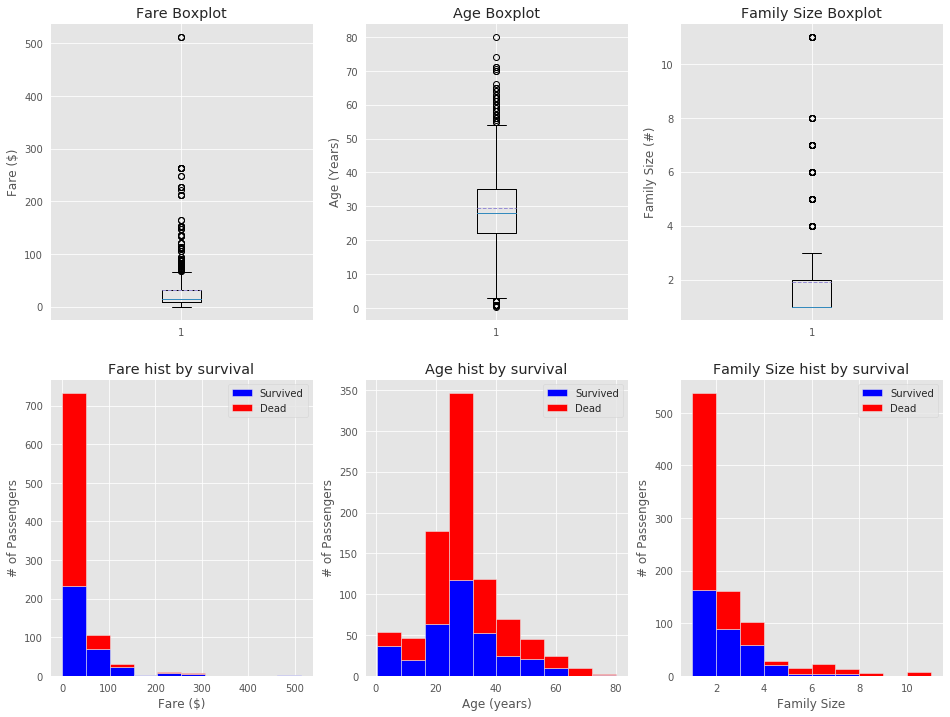

In [86]:
### Visuallization for EDA 
plt.figure(figsize=[16,12])
plt.subplot(231)
plt.boxplot(x=data['Fare'],showmeans=True,meanline = True)
plt.title('Fare Boxplot')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(data['Age'],showmeans=True,meanline = True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

plt.subplot(233)
plt.boxplot(data['FamilySize'],showmeans=True,meanline=True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

plt.subplot(234)
plt.hist(x=[data[data['Survived']==1]['Fare'], data[data['Survived']==0]['Fare']],stacked=True,color=['b','r'],label=['Survived','Dead'])
plt.title('Fare hist by survival')
plt.ylabel('# of Passengers')
plt.xlabel('Fare ($)')
plt.legend()

plt.subplot(235)
plt.hist(x=[data[data['Survived']==1]['Age'], data[data['Survived']==0]['Age']],stacked=True,color=['b','r'],label=['Survived','Dead'])
plt.title('Age hist by survival')
plt.ylabel('# of Passengers')
plt.xlabel('Age (years)')
plt.legend()

plt.subplot(236)
plt.hist(x=[data[data['Survived']==1]['FamilySize'], data[data['Survived']==0]['FamilySize']],stacked=True,color=['b','r'],label=['Survived','Dead'])
plt.title('Family Size hist by survival')
plt.ylabel('# of Passengers')
plt.xlabel('Family Size')
plt.legend()



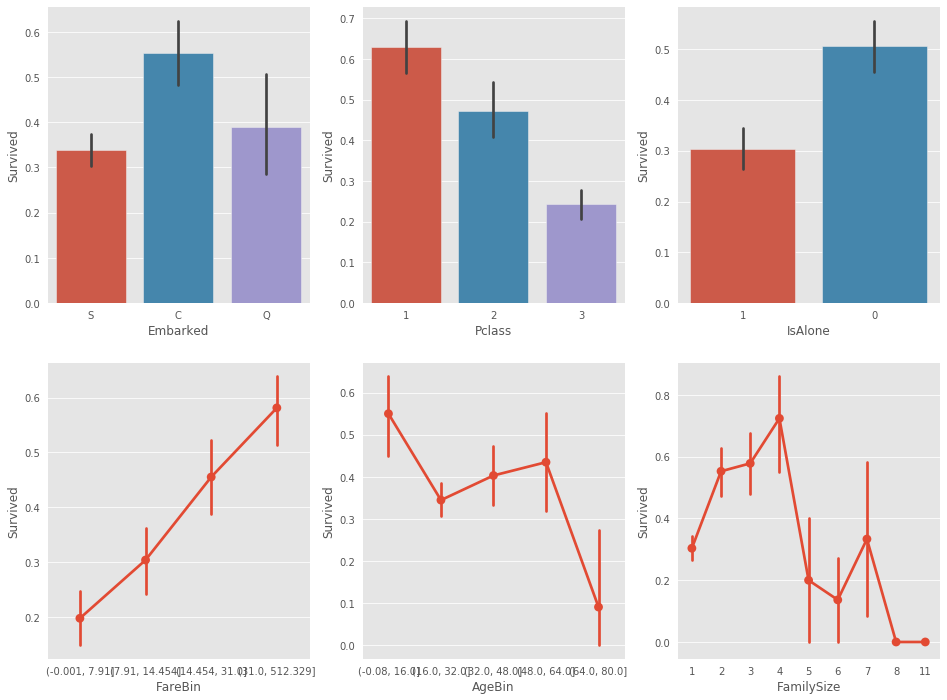

In [89]:
fig, saxis = plt.subplots(2, 3,figsize=(16,12))
sns.barplot(x='Embarked',y='Survived',data=data,ax=saxis[0,0])
sns.barplot(x='Pclass',y='Survived',order = [1,2,3],data=data,ax=saxis[0,1])
sns.barplot(x='IsAlone',y='Survived',order = [1,0],data=data,ax=saxis[0,2])

sns.pointplot(x='FareBin',y='Survived',data=data,ax=saxis[1,0])
sns.pointplot(x='AgeBin',y='Survived',data=data,ax=saxis[1,1])
sns.pointplot(x='FamilySize',y='Survived',data=data,ax=saxis[1,2])


Text(0.5, 1.0, 'Pclass vs FamilySize')

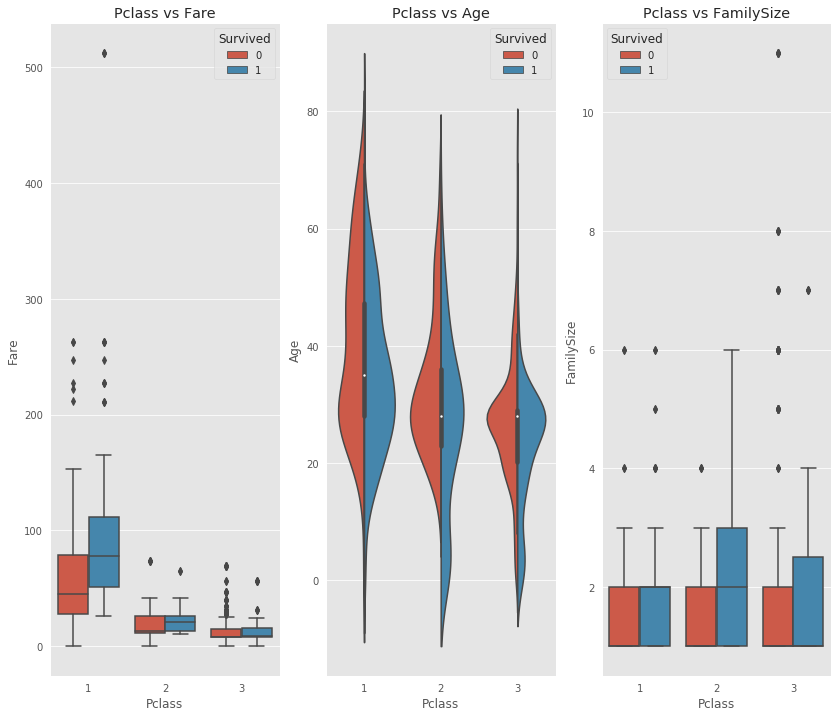

In [96]:
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(14,12))
sns.boxplot(x='Pclass',y='Fare',hue='Survived',data=data,ax=axis1)
axis1.set_title('Pclass vs Fare')

sns.violinplot(x='Pclass',y='Age',hue='Survived',split=True,data=data,ax=axis2)
axis2.set_title('Pclass vs Age')

sns.boxplot(x='Pclass',y='FamilySize',hue='Survived',data=data,ax=axis3)
axis3.set_title('Pclass vs FamilySize')

Text(0.5, 1, 'Sex vs IsAlone survival comparision')

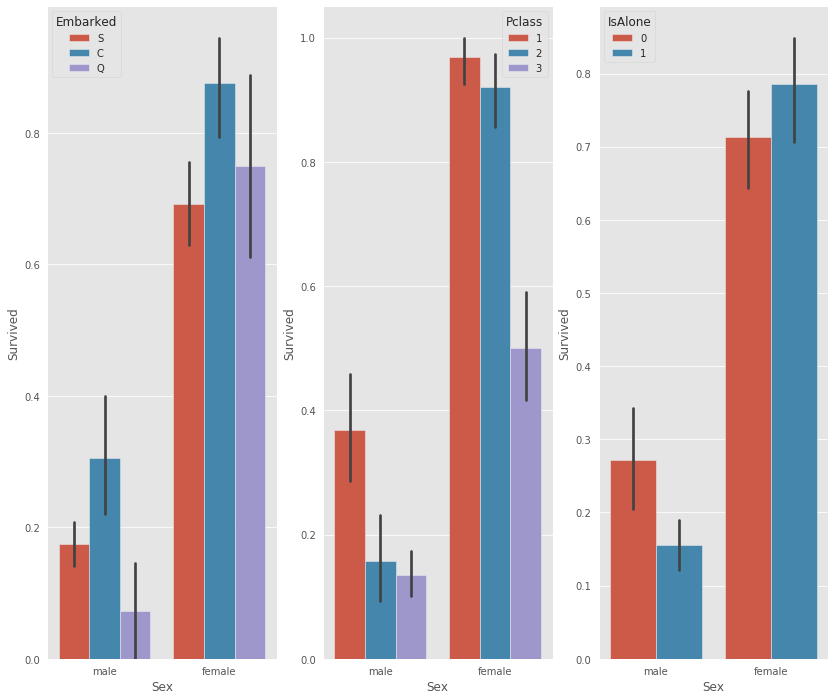

In [99]:
## Compare sex to other fields with survival rate 

fig, qaxis = plt.subplots(1,3,figsize=(14,12))

sns.barplot(x='Sex',y='Survived',hue='Embarked', data =data, ax=qaxis[0])
axis1.set_title('Sex vs Embarked survival comparision')

sns.barplot(x='Sex',y='Survived',hue='Pclass', data =data, ax=qaxis[1])
axis1.set_title('Sex vs Pclass survival comparision')

sns.barplot(x='Sex',y='Survived',hue='IsAlone', data =data, ax=qaxis[2])
axis1.set_title('Sex vs IsAlone survival comparision')

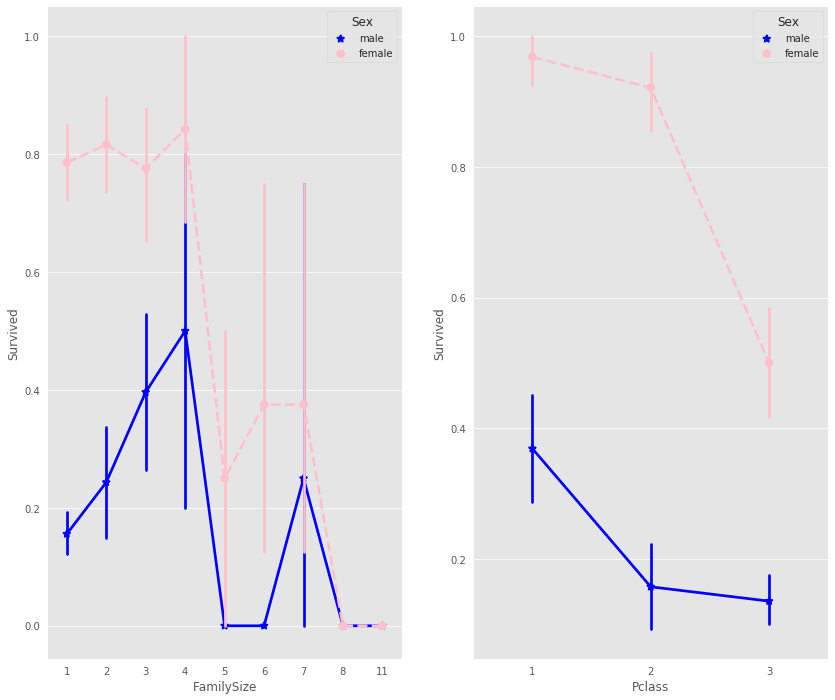

In [101]:
fig,(maxis1,maxis2) = plt.subplots(1,2,figsize=(14,12))
#how family affect sex and survival rate
sns.pointplot(x='FamilySize',y='Survived',hue='Sex',data=data,
             palette = {'male': 'blue','female':'pink'}, 
             markers = ['*','o'],linestyles=['-','--'],ax =maxis1)

#how class affect sex and survival rate
sns.pointplot(x='Pclass',y='Survived',hue='Sex',data=data,
             palette = {'male': 'blue','female':'pink'}, 
             markers = ['*','o'],linestyles=['-','--'],ax =maxis2)



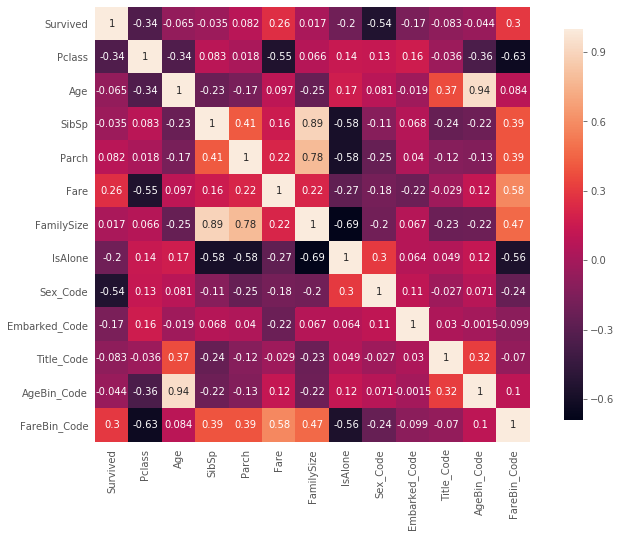

In [108]:
sns.heatmap(data.corr(),square=True,cbar_kws={'shrink':.9},annot=True)

In [124]:
MLA = [
    #ensemble
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(), 
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(), 
    
    #Gaussian Process
    gaussian_process.GaussianProcessClassifier(), 
    
    #GLM
    linear_model.LogisticRegressionCV(), 
    linear_model.PassiveAggressiveClassifier(), 
    linear_model.RidgeClassifierCV(), 
    linear_model.SGDClassifier(), 
    linear_model.Perceptron(), 
    
    #Naive Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(), 
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(), 
    
    #SVM
    svm.SVC(probability=True), 
    svm.NuSVC(probability=True),
    svm.LinearSVC(), 
    
    #Trees
    tree.DecisionTreeClassifier(), 
    tree.ExtraTreeClassifier(), 
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(), 
    discriminant_analysis.QuadraticDiscriminantAnalysis(), 
    
    #XG Boost
    XGBClassifier()
        ]
cv_split = model_selection.ShuffleSplit(n_splits=10,test_size=0.3,train_size=0.6,random_state =0)

MLA_columns = ['MLA Name','MLA Parameters','MLA train accuracy mean','MLA test accuracy mean','MLA test accuracy 3*STD','MLA Time']
MLA_compare = pd.DataFrame(columns=MLA_columns)
MLA_predict = data[Target]

row_index=0
for alg in MLA: 
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'MLA Name'] = MLA_name
    MLA_compare.loc[row_index,'MLA Parameters'] = str(alg.get_params())
    
    cv_results = model_selection.cross_validate(alg,data[data_x_bin],data[Target],cv=cv_split)
    MLA_compare.loc[row_index,'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index,'MLA train accuracy mean'] = cv_results['test_score'].mean()
    MLA_compare.loc[row_index,'MLA test accuracy mean'] = cv_results['test_score'].mean()
    MLA_compare.loc[row_index,'MLA test accuracy 3*STD'] = cv_results['test_score'].std()*3
    
    alg.fit(data[data_x_bin],data[Target])
    MLA_predict[MLA_name] = alg.predict(data[data_x_bin])
    row_index+=1
    
MLA_compare.sort_values(by=['MLA test accuracy mean'],ascending=False,inplace=True)
MLA_compare
    

,MLA Name,MLA Parameters,MLA train accuracy mean,MLA test accuracy mean,MLA test accuracy 3*STD,MLA Time
21,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.829478,0.829478,0.0527546,0.0232859
14,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.826119,0.826119,0.0453876,0.0351948
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.825746,0.825746,0.0541611,0.0109238
17,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.822761,0.822761,0.0532746,0.00303261
15,NuSVC,"{'cache_size': 200, 'class_weight': None, 'coe...",0.822761,0.822761,0.0493681,0.0398094
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.822015,0.822015,0.0682836,0.00916605
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.822015,0.822015,0.0529916,0.0509634
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.821642,0.821642,0.0522175,0.00958476
13,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.813806,0.813806,0.0690863,0.00251985
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.81194,0.81194,0.0498606,0.0431774


Text(0, 0.5, 'Alg')

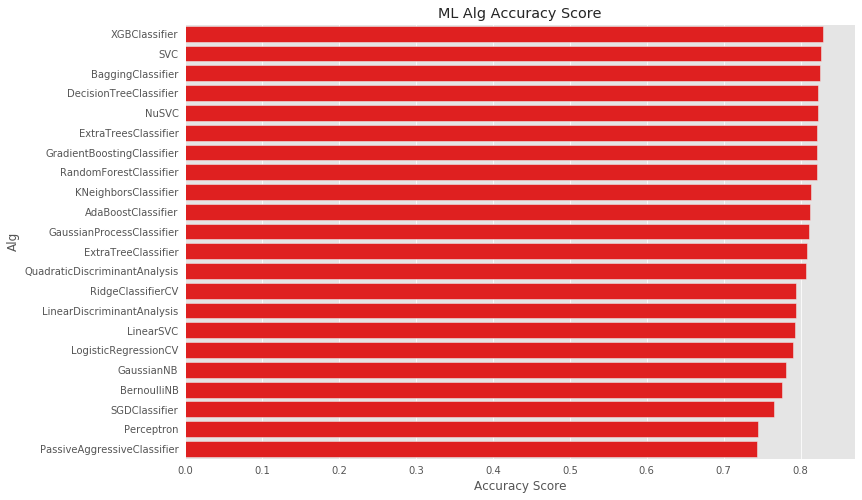

In [126]:
sns.barplot(x='MLA test accuracy mean',y='MLA Name',data= MLA_compare,color='r')

plt.title('ML Alg Accuracy Score')
plt.xlabel('Accuracy Score')
plt.ylabel('Alg')

In [121]:
cv_results

{'fit_time': array([0.07118464, 0.05555606, 0.05557203, 0.05536127, 0.05550957,
        0.05555105, 0.05545998, 0.05545187, 0.05544209, 0.05528212]),
 'score_time': array([0.00876307, 0.008255  , 0.00822854, 0.00826073, 0.00816298,
        0.00819874, 0.00823092, 0.00814247, 0.00821304, 0.00810885]),
 'test_score': array([0.81716418, 0.79104478, 0.80970149, 0.79850746, 0.82835821,
        0.80597015, 0.79477612, 0.79850746, 0.8358209 , 0.83955224])}